<div style="font-family: Arial; padding: 20px; border: 1px solid #ddd; border-radius: 10px; box-shadow: 2px 2px 12px #aaa;">

### <span style="color: #2e6c80;">&#128273; Problem Statement: Classifying Amazon Reviews for Luxury Beauty Products Based on Customer Ratings Using NLP</span>

---

#### <span style="color: #a46497;">&#128161; Impact</span>
<span style="font-size: 16px;">Reviews serve as a critical feedback mechanism for products, particularly in the realm of e-commerce and specifically in the luxury beauty sector. While these reviews are often summarized through a numerical rating system, the true value lies in the textual content of the review itself. The objective of this project is to build a classifier that can understand the semantics of a review text and assign it the most appropriate numerical rating.</span>

---

#### <span style="color: #a46497;">&#128220; Background</span>
<span style="font-size: 16px;">Amazon's product ratings for Luxury Beauty items are an aggregate of individual customer reviews, each represented by an integer value ranging from one to five stars. This forms the basis for a supervised multi-class classification problem, where the review text is the primary feature for prediction.</span>

<span style="font-size: 16px;">The project will explore various Natural Language Processing (NLP) techniques such as word embedding, topic modeling, and sentiment analysis. Subsequently, multiple machine learning algorithms will be employed to identify the most accurate estimator for the classifier.</span>

---

#### <span style="color: #a46497;">&#128202; Datasets</span>
<span style="font-size: 16px;">The dataset comprises customer reviews for Luxury Beauty products listed on Amazon. It includes multiple attributes that are important for the classification task.</span>

**&#128302; Data Dictionary:**
- **asin**: Unique ID of the product being reviewed (string)
- **helpful**: List containing the number of helpful votes and total votes for the review (list)
- **overall**: Rating given by the reviewer (int64)
- **reviewText**: The text of the review (string)
- **reviewerID**: Unique ID of the reviewer (string)
- **reviewerName**: Name of the reviewer (string)
- **summary**: Summary headline of the review (string)
- **unixReviewTime**: Unix timestamp for the review (string)
- **vote**: Number of votes for the review (int64)
- **verified**: Whether the review is verified or not (boolean)
- **style**: Additional product details (dictionary)
- **image**: Image URLs related to the review (list)

</div>


#### <span style="color: #a46497;">&#128295; Data Wrangling</span>
<span style="font-size: 16px;">This section will focus on cleaning and structuring the raw data into a more usable format. This includes tasks like handling missing values, type conversion, and encoding categorical variables. Effective data wrangling simplifies the downstream tasks in data analysis and model building.</span>


In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

#### <span style="color: #a46497;">&#128196; Data Sourcing and Loading</span>
<span style="font-size: 16px;">The DataFrame (`df`) is created from the Amazon dataset. Two scenarios are considered for data loading:</span>
  
  - <span style="font-size: 16px;">If the file has been downloaded, then the dataset is loaded from the local file.</span>
  - <span style="font-size: 16px;">Otherwise, the file is accessed and extracted directly from the repository.</span>


In [ ]:
import os
import pandas as pd

dataset = "Luxury_Beauty.json"

if os.path.isfile(dataset):
    df = pd.read_json("Luxury_Beauty.json", lines=True)
else:
    url = r"https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Luxury_Beauty.json.gz"
    df = pd.read_json(url, compression='gzip', lines=True)

df = df[:500]
display(df.head(10))

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         500 non-null    int64 
 1   vote            36 non-null     object
 2   verified        500 non-null    bool  
 3   reviewTime      500 non-null    object
 4   reviewerID      500 non-null    object
 5   asin            500 non-null    object
 6   reviewerName    500 non-null    object
 7   reviewText      499 non-null    object
 8   summary         500 non-null    object
 9   unixReviewTime  500 non-null    int64 
 10  style           485 non-null    object
 11  image           3 non-null      object
dtypes: bool(1), int64(2), object(9)
memory usage: 43.6+ KB
None



Only the overall and the unixReviewTime series are stored as integers. The rest are interpreted as strings (objects).


In [4]:
from datetime import datetime

condition = lambda row: datetime.fromtimestamp(row).strftime("%m-%d-%Y")
df["unixReviewTime"] = df["unixReviewTime"].apply(condition)



The unixReviewTime is converted from Unix time to the more intuitive datetime datatype.


In [5]:
df.drop(labels="reviewTime", axis=1, inplace=True)

display(df.head())

,overall,vote,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,2,3,True,A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,06-15-2010,NaN,NaN
1,5,14,True,A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,01-07-2010,NaN,NaN
2,5,NaN,True,A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,04-18-2018,{'Size:': ' 3.5 oz.'},NaN
3,5,NaN,True,A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,04-18-2018,{'Size:': ' 3.5 oz.'},NaN
4,5,NaN,True,A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,04-17-2018,{'Size:': ' 3.5 oz.'},NaN




The reviewTime is dropped since the unixReviewTime series more accurately describes the time when each review was posted.




Each review is associated with a rating stored under the overall field. This serves as the quantified summary of a given review and will thus be used as the ground truth labels for the model.


In [6]:
print(df.overall.unique())

[2 5 4 1 3]


### <span style="color: #2e6c80;">&#128269; NLP Pre-Processing</span>

---

#### <span style="color: #a46497;">&#128288; Tokenization</span>
<span style="font-size: 16px;">The primary focus of our pre-processing will be the `reviewText` column. The goal is to tokenize each review, effectively converting them into a list of words or "tokens." These tokens will serve as the building blocks for our NLP model.</span>

---

#### <span style="color: #a46497;">&#128187; Handling HTML Entities</span>
<span style="font-size: 16px;">Our dataset contains HTML entities, which are numerical or named character references that might have been introduced due to the use of an HTML parser. Examples include special characters like apostrophes (`&apos;`) and en dashes (`&ndash;`).</span>

<span style="font-size: 16px;">To make the text more amenable for NLP operations, it is essential to decode these HTML entities. We will employ Python's `html` library for this purpose.</span>

---

#### <span style="color: #a46497;">&#128473; Punctuation and Special Characters</span>
<span style="font-size: 16px;">Since punctuation marks and special HTML entities do not contribute meaningfully to our NLP tasks, we will remove them from our reviews.</span>

---


In [7]:
# Import the html library for decoding HTML entities
import html
import re

# Sample review
sample_review = df["reviewText"].iloc[0]
print("Original Sample Review:")
print(sample_review)

# Decode HTML entities
decoded_review = html.unescape(sample_review)
print("\nDecoded Sample Review:")
print(decoded_review)

# Define pattern for HTML entities
pattern = r"\&\#[0-9]+\;"

# Remove HTML entities from the entire DataFrame
df["preprocessed"] = df["reviewText"].str.replace(pat=pattern, repl="", regex=True)

# Print the preprocessed sample review
preprocessed_sample_review = df["preprocessed"].iloc[0]
print("\nPreprocessed Sample Review:")
print(preprocessed_sample_review)


Original Sample Review:
I bought two of these 8.5 fl oz hand cream, and neither of the dispensers work.  The hand cream is wonderful, but very thick, so I don't see I can get much out by shaking it out, since the dispensers seem to be non-operable.

Decoded Sample Review:
I bought two of these 8.5 fl oz hand cream, and neither of the dispensers work.  The hand cream is wonderful, but very thick, so I don't see I can get much out by shaking it out, since the dispensers seem to be non-operable.

Preprocessed Sample Review:
I bought two of these 8.5 fl oz hand cream, and neither of the dispensers work.  The hand cream is wonderful, but very thick, so I don't see I can get much out by shaking it out, since the dispensers seem to be non-operable.


---

### <span style="color: #2e6c80;">&#128269; Extracting the Root Word</span>

---

#### <span style="color: #a46497;">&#128214; The Importance of Root Words</span>
<span style="font-size: 16px;">In Natural Language Processing (NLP), the frequency of a word's occurrence can offer significant insights. To preserve the relational context between words in different forms (e.g., "learn" and "learning"), it is crucial to reduce them to their root form.</span>

---

#### <span style="color: #a46497;">&#9881; Techniques for Extracting the Root Word</span>
<span style="font-size: 16px;">
  
- **Lemmatization**: This technique reduces words to their base form while considering the part-of-speech and grammatical nuances. We will be using the `WordNetLemmatizer` from the Natural Language Toolkit (NLTK).
  
- **Stemming**: An alternative but less accurate technique that truncates words to their base form without considering grammatical factors.
</span>

---

#### <span style="color: #a46497;">&#128736; Implementation</span>
<span style="font-size: 16px;">
  
1. **Sentence Tokenization**: Each review is broken down into a list of sentences.
2. **Word Tokenization**: Each sentence is further tokenized into words.
3. **Part-of-Speech Tagging**: Every word is tagged with its part-of-speech.
4. **Lemmatization**: Words are lemmatized based on their part-of-speech tags.

The lemmatized words are then reassembled to form the processed review text.
</span>

---


In [8]:
# Importing necessary modules from NLTK
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet

# Define the function to download necessary NLTK resources
def download_nltk_resources(resources):
    for resource in resources:
        try:
            nltk.data.find("tokenizers/" + resource)
        except LookupError:
            nltk.download(resource)

# Define the function to lemmatize individual words based on POS tags
def lemmatize_word(tagged_token):
    lemma = WordNetLemmatizer()
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

# Define the function to lemmatize entire document
def lemmatize_doc(document):
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

# List of resources to download
resources = ["wordnet", "stopwords", "punkt", "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]

# Download resources (uncomment this line when running locally)
download_nltk_resources(resources)

# Apply Lemmatization (uncomment this line when running locally)
df["preprocessed"] = df["preprocessed"].apply(lambda row: lemmatize_doc(row) if isinstance(row, str) else row)

# Uncomment to print a sample preprocessed review (when running locally)
# print(df["preprocessed"].iloc[0])


[nltk_data] Downloading package wordnet to /home/ehsan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ehsan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ehsan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/ehsan/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!


---

### <span style="color: #2e6c80;">&#128441; Removing Accents</span>

---

#### <span style="color: #a46497;">&#128240; Text Normalization</span>
<span style="font-size: 16px;">To ensure uniformity in text data, it is crucial to remove accents from characters. This is particularly important for words like "naïve," which should not be distinguished from "naive" in the context of text analysis.</span>

---

#### <span style="color: #a46497;">&#128187; Implementation</span>
<span style="font-size: 16px;">We will use Python's `unicodedata` library to normalize text from UTF-8 to ASCII encoding. This will remove all accent marks from characters, making the text easier to process.</span>

---


In [9]:
# Import the unicodedata library for text normalization
from unicodedata import normalize

# Define the function to remove accents from text
def remove_accent(text):
    return normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")

# Remove accents from the 'preprocessed' column
# Note: This line is for you to run in your local environment as it depends on the previous preprocessed data
df["preprocessed"] = df["preprocessed"].apply(lambda row: remove_accent(row) if isinstance(row, str) else row)

---

### <span style="color: #2e6c80;">&#128295; Additional Preprocessing Steps</span>

---

#### <span style="color: #a46497;">&#128473; 1. Removing Punctuations</span>
<span style="font-size: 16px;">To make the text more uniform and easier to process, we remove all punctuations, retaining only whitespaces and alphanumeric characters.</span>

---

#### <span style="color: #a46497;">&#8681; 2. Converting to Lower Case</span>
<span style="font-size: 16px;">All characters are converted to their lower-case form to ensure uniformity. This makes words like "iPhone" and "iphone" indistinguishable, thereby reducing data sparsity.</span>

---

#### <span style="color: #a46497;">&#10071; 3. Removing Stop Words</span>
<span style="font-size: 16px;">Commonly used words, often referred to as "stop words" (e.g., "the," "is," "in"), are removed. These words don't add much meaning in text analysis and their removal can enhance the performance of NLP algorithms.</span>

---

#### <span style="color: #a46497;">&#9200; 4. Removing Extra Spaces</span>
<span style="font-size: 16px;">Any extra spaces between words are removed to clean up the text.</span>

---


In [10]:
# Importing stopwords from nltk.corpus
from nltk.corpus import stopwords

# Define regex pattern for removing punctuations
pattern_punct = r"[^\w\s]"

# Define regex pattern for removing extra spaces
pattern_space = r"[\s]+"

# Get the list of stop words
stop_words = stopwords.words("english")
# Remove apostrophes from stop words
stop_words = [word.replace("\'", "") for word in stop_words]

# Define function to remove stop words
def remove_stop_words(row):
    return " ".join([token for token in str(row).split(" ") if token not in stop_words])

# Remove punctuations
df["preprocessed"] = df["preprocessed"].str.replace(pat=pattern_punct, repl=" ", regex=True)

# Convert to lower case
df["preprocessed"] = df["preprocessed"].str.lower()

# Remove stop words
df["preprocessed"] = df["preprocessed"].apply(remove_stop_words)

# Remove extra spaces
df["preprocessed"] = df["preprocessed"].str.replace(pat=pattern_space, repl=" ", regex=True)

# Uncomment to print a sample preprocessed review (when running locally)
print(df["preprocessed"].iloc[0])


buy two 8 5 fl oz hand cream neither dispenser work hand cream wonderful thick see get much shake since dispenser seem non operable


---

### <span style="color: #2e6c80;">&#9881; Advanced NLP Techniques</span>

---

#### <span style="color: #a46497;">&#127344; Tokenization</span>
<span style="font-size: 16px;">In this step, each review is broken down into individual words or tokens, creating a tokenized representation of our corpus (a collection of all documents).</span>

---

#### <span style="color: #a46497;">&#128508; Phrase Modeling</span>
<span style="font-size: 16px;">The sequential order of words is often significant in NLP. To capture the semantics, we group neighboring words that often appear together into phrases.</span>

##### <span style="color: #a46497;">&#10122; Criteria for Phrase Modeling</span>

- **Bigrams**: Two adjacent words that frequently appear together are grouped as a single token.
- **Trigrams**: Similar to bigrams but considers three words.

---

#### <span style="color: #a46497;">&#128736; Implementation</span>
<span style="font-size: 16px;">

1. **Corpora Preparation**: Extract the `preprocessed` column to constitute our corpora.
2. **Tokenization**: Use the `split` method to tokenize each review.
3. **Bigram and Trigram Modeling**: Utilize gensim's `Phrases` and `Phraser` to generate bigrams and trigrams based on set criteria.
</span>

---


In [11]:
# Code comments for the tokenization and phrase modeling section

# Importing Phrases and Phraser from gensim.models
from gensim.models.phrases import Phraser , Phrases
#from gensim.models import Phrases

# Extract the 'preprocessed' column to form the corpora
corpora = df["preprocessed"].values

# Tokenize each review in the corpora
tokenized = [corpus.split(" ") for corpus in corpora]

# Define the bigram model
bi_gram = Phrases(tokenized, min_count=300, threshold=50)

# Define the trigram model
tri_gram = Phrases(bi_gram[tokenized], min_count=300, threshold=50)

# Extract unique unigram tokens
uni_gram_tokens = set([token for text in tokenized for token in text])
# Remove empty strings
uni_gram_tokens = set(filter(lambda x: x != "", uni_gram_tokens))

# Uncomment to print a sample (when running locally)
print(list(uni_gram_tokens)[:50])





['wife', 'one', 'ton', 'excellent', 'fragrant', 'take', 'slip', 'saved', 'intensive', 'farm', 'uk', 'awesome', 'course', 'eye', 'perfumy', 'anyway', 'staple', 'dad', 'sore', 'exceptional', 'good', 'round', 'gentle', 'hopefully', 'crazy', 'aware', 'wrong', 'remarkable', 'quarter', 'cant', 'belong', 'odor', 'legs', 'second', 'c', 'tool', 'woman', 'original', 'greasy', 'handwashing', 'love', 'old', 'man', 'tried', 'combination', 'family', 'makeup', 'patch', 'came', '30']


In [12]:
corpora = df["preprocessed"].values
tokenized = [corpus.split(" ") for corpus in corpora]

print(tokenized[0])


from gensim.models import Phrases
from gensim.models.phrases import Phraser

bi_gram = Phrases(tokenized, min_count=300, threshold=50)

tri_gram = Phrases(bi_gram[tokenized], min_count=300, threshold=50)



uni_gram_tokens = set([token for text in tokenized for token in text])
uni_gram_tokens = set(filter(lambda x: x != "", uni_gram_tokens))

print(list(uni_gram_tokens)[:50])

bi_gram_tokens = set([token.decode("utf-8") if isinstance(token, bytes) else token for token in bi_gram.vocab.keys()])
tri_gram_tokens = set([token.decode("utf-8") if isinstance(token, bytes) else token for token in tri_gram.vocab.keys()])

bi_grams_only = bi_gram_tokens.difference(uni_gram_tokens)
tri_grams_only = tri_gram_tokens.difference(bi_gram_tokens)

['buy', 'two', '8', '5', 'fl', 'oz', 'hand', 'cream', 'neither', 'dispenser', 'work', 'hand', 'cream', 'wonderful', 'thick', 'see', 'get', 'much', 'shake', 'since', 'dispenser', 'seem', 'non', 'operable']
['wife', 'one', 'ton', 'excellent', 'fragrant', 'take', 'slip', 'saved', 'intensive', 'farm', 'uk', 'awesome', 'course', 'eye', 'perfumy', 'anyway', 'staple', 'dad', 'sore', 'exceptional', 'good', 'round', 'gentle', 'hopefully', 'crazy', 'aware', 'wrong', 'remarkable', 'quarter', 'cant', 'belong', 'odor', 'legs', 'second', 'c', 'tool', 'woman', 'original', 'greasy', 'handwashing', 'love', 'old', 'man', 'tried', 'combination', 'family', 'makeup', 'patch', 'came', '30']


---

### <span style="color: #2e6c80;">&#128293; Final Text Preprocessing Steps</span>

---

#### <span style="color: #a46497;">&#10060; Removing Single-Character Tokens</span>
<span style="font-size: 16px;">We will remove any tokens that consist of single characters, as they usually don't carry meaningful information.</span>

---

#### <span style="color: #a46497;">&#128214; Creating the Vocabulary</span>
<span style="font-size: 16px;">The vocabulary consists of unique tokens across all reviews, each mapped to a unique ID.</span>

---

#### <span style="color: #a46497;">&#128202; Count-Based Feature Engineering: Bag of Words Model</span>
<span style="font-size: 16px;">In this model, each document is represented as a vector, where each element corresponds to the frequency of a unique token in that document.</span>

---

#### <span style="color: #a46497;">&#128187; Python Code for Final Steps</span>
<span style="font-size: 16px;">Firstly, let's remove single-character tokens from each document.</span>

---


In [13]:
# Remove single-character tokens
tokenized = [list(filter(lambda x: len(x) > 1, document)) for document in tokenized]
print(tokenized[0])

['buy', 'two', 'fl', 'oz', 'hand', 'cream', 'neither', 'dispenser', 'work', 'hand', 'cream', 'wonderful', 'thick', 'see', 'get', 'much', 'shake', 'since', 'dispenser', 'seem', 'non', 'operable']


Now, let's create the vocabulary using gensim's `Dictionary` class.


In [14]:
from gensim.corpora.dictionary import Dictionary

# Create the vocabulary
vocabulary = Dictionary(tokenized)

# Print the first 10 words in the vocabulary
vocabulary_keys = list(vocabulary.token2id)[:10]
for key in vocabulary_keys:
    print(f"ID: {vocabulary.token2id[key]}, Token: {key}")

ID: 0, Token: buy
ID: 1, Token: cream
ID: 2, Token: dispenser
ID: 3, Token: fl
ID: 4, Token: get
ID: 5, Token: hand
ID: 6, Token: much
ID: 7, Token: neither
ID: 8, Token: non
ID: 9, Token: operable


Finally, let's create the Bag of Words (BoW) representation for each document.


In [15]:
# Create Bag of Words model for each document
bow = [vocabulary.doc2bow(doc) for doc in tokenized]

# Print the word frequency for the first document
for idx, freq in bow[0]:
    print(f"Word: {vocabulary.get(idx)}, Frequency: {freq}")

Word: buy, Frequency: 1
Word: cream, Frequency: 2
Word: dispenser, Frequency: 2
Word: fl, Frequency: 1
Word: get, Frequency: 1
Word: hand, Frequency: 2
Word: much, Frequency: 1
Word: neither, Frequency: 1
Word: non, Frequency: 1
Word: operable, Frequency: 1
Word: oz, Frequency: 1
Word: see, Frequency: 1
Word: seem, Frequency: 1
Word: shake, Frequency: 1
Word: since, Frequency: 1
Word: thick, Frequency: 1
Word: two, Frequency: 1
Word: wonderful, Frequency: 1
Word: work, Frequency: 1


---

### <span style="color: #2e6c80;">&#9881; Advanced Feature Engineering Techniques for NLP</span>

---

#### <span style="color: #a46497;">&#128200; TF-IDF Model</span>
<span style="font-size: 16px;">The TF-IDF model assigns continuous values to tokens based on their importance in the document and the entire corpus. This allows for more nuanced features than simple term frequency.</span>

---

#### <span style="color: #a46497;">&#127344; Word Embedding: Word2Vec Model</span>
<span style="font-size: 16px;">Word2Vec captures semantic meaning by considering the context in which words appear. This results in a dense vector representation for each token.</span>

---

#### <span style="color: #a46497;">&#128203; Final Dataframe</span>
<span style="font-size: 16px;">We'll create a final dataframe where each row corresponds to a product review and columns represent feature-engineered tokens.</span>

---

#### <span style="color: #a46497;">&#128187; Python Code for Advanced Feature Engineering</span>
<span style="font-size: 16px;">First, let's create the TF-IDF model using the Bag of Words (BoW) representation we generated earlier.</span>

---


In [16]:
from gensim.models.tfidfmodel import TfidfModel

# Create the TF-IDF model
tfidf = TfidfModel(bow)

# Display TF-IDF weights for the first document
for idx, weight in tfidf[bow[0]]:
    print(f"Word: {vocabulary.get(idx)}, Weight: {weight:.3f}")

Word: buy, Weight: 0.132
Word: cream, Weight: 0.140
Word: dispenser, Weight: 0.549
Word: fl, Weight: 0.275
Word: get, Weight: 0.126
Word: hand, Weight: 0.067
Word: much, Weight: 0.165
Word: neither, Weight: 0.275
Word: non, Weight: 0.189
Word: operable, Weight: 0.275
Word: oz, Weight: 0.226
Word: see, Weight: 0.213
Word: seem, Weight: 0.183
Word: shake, Weight: 0.275
Word: since, Weight: 0.183
Word: thick, Weight: 0.213
Word: two, Weight: 0.204
Word: wonderful, Weight: 0.132
Word: work, Weight: 0.088


Next, we'll create word vectors using the Word2Vec model.


In [17]:
%%time
import numpy as np
from gensim.models import word2vec

# Suppress scientific notation
np.set_printoptions(suppress=True)

# Parameters for Word2Vec
feature_size = 100
context_size = 20
min_word = 1

# Create the Word2Vec model
word_vec = word2vec.Word2Vec(tokenized, vector_size=feature_size, window=context_size, min_count=min_word, seed=42)

# Unpack vocabulary and corresponding indices
word_vec_unpack = [(word, word_vec.wv.key_to_index[word]) for word in word_vec.wv.index_to_key]

# Separate tokens and indexes
tokens, indexes = zip(*word_vec_unpack)

# Create DataFrame from word vectors
word_vec_df = pd.DataFrame(word_vec.wv.vectors[indexes, :], index=tokens)


CPU times: user 43.1 ms, sys: 813 µs, total: 43.9 ms
Wall time: 43.1 ms


---

### Finalizing the Dataframe for Machine Learning

#### Averaging Word Vectors
To represent each review by a single feature vector, we average the word vectors for all the words in the review. This approach gives us a fixed-length feature vector for each review while capturing the semantic essence of the text.

#### Appending Labels
We'll also append the actual ratings to our dataframe as labels for supervised learning.

---

#### Python Code for Final Steps

First, we'll create an array by averaging the word vectors for each tokenized review.

In [18]:
import numpy as np

# Convert the list of tokenized documents to a NumPy array
tokenized_array = np.array(tokenized)

# Average the word vectors for each tokenized document
model_array = np.array([word_vec_df.loc[doc].mean(axis=0) for doc in tokenized_array])


Now, let's create our final dataframe by appending the "overall" ratings as labels.


In [19]:
import pandas as pd

# Create the final dataframe
model_df = pd.DataFrame(model_array)

# Add the 'overall' ratings as labels
model_df["label"] = df["overall"]

# Display the first few rows of the dataframe
display(model_df.head())

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.038052,0.004865,-0.024110,0.010721,-0.037630,0.041794,0.032024,0.056262,-0.050149,-0.039923,...,0.093524,0.021550,-0.060988,0.039820,-0.020458,-0.010438,0.042767,-0.049443,-0.019308,2
1,0.052540,0.004689,-0.031707,0.012001,-0.049165,0.052489,0.039805,0.071640,-0.063980,-0.053687,...,0.119244,0.029261,-0.079338,0.049145,-0.025435,-0.011774,0.054912,-0.063711,-0.025719,5
2,0.091265,0.012553,-0.058918,0.025599,-0.083858,0.090943,0.065649,0.120296,-0.110941,-0.100185,...,0.207992,0.050040,-0.134394,0.086564,-0.041691,-0.028928,0.092000,-0.108401,-0.044358,5
3,0.058757,0.004504,-0.032863,0.013218,-0.058132,0.065929,0.042285,0.082873,-0.076799,-0.064917,...,0.142833,0.031836,-0.089993,0.059574,-0.028778,-0.014917,0.063816,-0.075977,-0.026728,5
4,0.042354,0.005214,-0.023693,0.007682,-0.038925,0.042409,0.034456,0.060884,-0.053595,-0.042374,...,0.099172,0.023725,-0.063907,0.043111,-0.023355,-0.011738,0.047667,-0.051948,-0.021862,5


---

### <span style="color: #2e6c80;">&#128202; Visualizing Data using Principal Component Analysis (PCA)</span>

---

#### <span style="color: #a46497;">&#10148; Objective</span>
<span style="font-size: 16px;">We aim to reduce the dimensionality of our feature set (`model_df`) to visualize if the reviews with the same ratings are clustering together in the two-dimensional space. If the points belonging to the same rating are clustered together, it likely indicates a well-defined pattern that a machine learning algorithm can learn.</span>

---

#### <span style="color: #a46497;">&#9879; Procedure</span>
<span style="font-size: 16px;">We use PCA to reduce the dimensions from 100 to just two. We then plot these two dimensions, color-coding the points based on their actual ratings.</span>

---

#### <span style="color: #a46497;">&#128187; Python Code for PCA Visualization</span>
<span style="font-size: 16px;">First, let's prepare our data for PCA by sampling and dropping NaN values.</span>

---


In [20]:
# Prepare the data
pca_df = model_df.reset_index()
pca_df = model_df.dropna(axis=0).iloc[:,1:]
pca_df = pca_df.iloc[::50]

Now, let's perform PCA to reduce the dimensions to 2.


In [21]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(pca_df.iloc[:, :-1])
labels = pca_df["label"]


Finally, let's plot the 2D representation of our data, color-coded by the actual ratings.


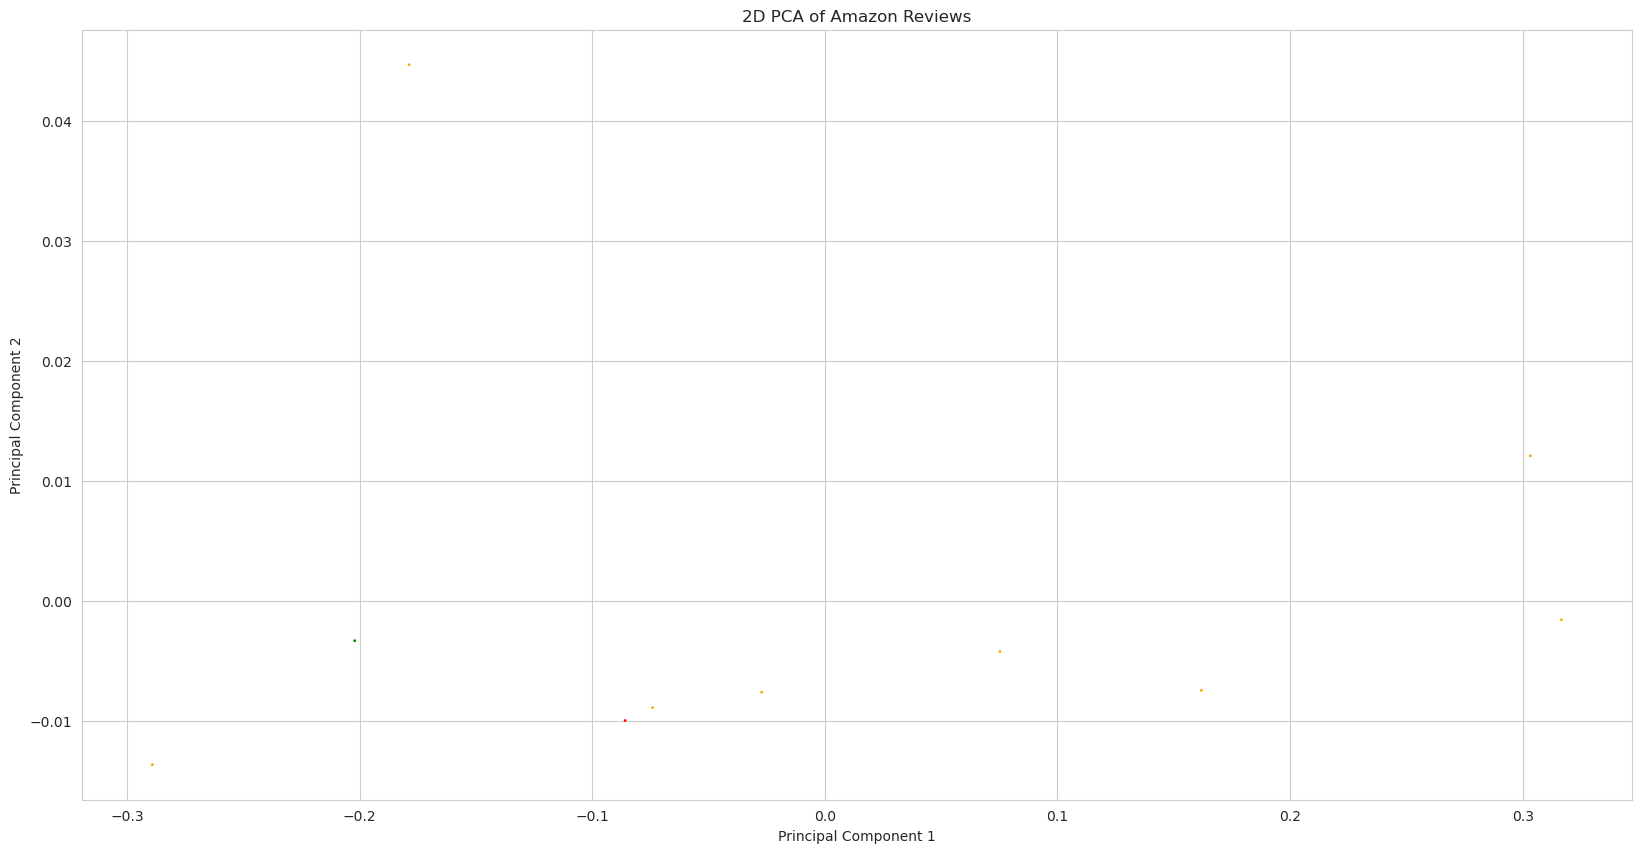

In [22]:
import matplotlib.pyplot as plt

# Prepare plot components
x_axis = pca_result[:, 0]
y_axis = pca_result[:, 1]
color_map = labels.map({1: "blue", 2: "red", 3: "yellow", 4: "green", 5: "orange"})

# Create the plot
f, axes = plt.subplots(figsize=(20, 10))
plt.scatter(x_axis, y_axis, color=color_map, s=1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Amazon Reviews')
plt.show()

---

### <span style="color: #2e6c80;">&#128269; Exploratory Data Analysis on Word Embeddings</span>

---

#### <span style="color: #a46497;">&#10148; Objective</span>
<span style="font-size: 16px;">We aim to explore and understand the semantic relationships between words in our Amazon dataset. We will use the `word_vec` model, which contains word embeddings trained on our corpus, to find the most similar words to a given set of common words.</span>

---

#### <span style="color: #a46497;">&#128214; Identifying Most Similar Words</span>
<span style="font-size: 16px;">We will start with five common words often appearing in product reviews: "color", "love", "use", "great", and "product". For each of these words, we will identify the top 5 most similar words based on the word embeddings.</span>

---

#### <span style="color: #a46497;">&#128187; Python Code</span>
<span style="font-size: 16px;">Here's how you can find the most similar words for each word in your `word_bank`:</span>

---


In [1]:
import numpy as np
from collections import Counter
word_count = Counter(word_vec_df.index.tolist())
common_words = word_count.most_common(5)
# Initialize the word_bank with common words
word_bank = [word[0] for word in common_words]


# Loop through each word to find its most similar words
for word in word_bank:
    related_vec = word_vec.wv.most_similar(word, topn=5)
    related_words = np.array(related_vec)[:, 0]
    print(f"{word}: {related_words}")


NameError: name 'word_vec_df' is not defined

---

### Visualizing Word Embeddings using t-SNE

#### Objective

To visualize the semantic relationships between frequently occurring words in our Amazon dataset, we'll employ t-Distributed Stochastic Neighbor Embedding (t-SNE). This technique will help us reduce the high-dimensional word vectors into a 2D space where similar words cluster together.

#### t-SNE Visualization

We'll visualize the words in `word_bank`, along with their most similar words, using t-SNE. The 2D scatter plot will help us understand the spatial distance between related words.

---

#### Python Code


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)

# Extract vectors of words in word_bank
sample_vecs = word_vec.wv[set(word_bank)]

# Apply t-SNE transformation
sample_tsne = tsne.fit_transform(sample_vecs)

# Get 2D coordinates
tsne_x = sample_tsne[:, 0]
tsne_y = sample_tsne[:, 1]

# Plot t-SNE results
f, axes = plt.subplots(figsize=(20, 7))
ax = plt.scatter(x=tsne_x, y=tsne_y)

# Annotate each point with the corresponding word
for label, x, y in zip(word_bank, tsne_x, tsne_y):
    plt.annotate(label, xy=(x + 3, y + 3))

plt.show()


In [148]:
df

,overall,vote,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image,preprocessed
0,2,3,True,A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,06-15-2010,NaN,NaN,buy two 8 5 fl oz hand cream neither dispenser...
1,5,14,True,A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,01-07-2010,NaN,NaN,believe year try many many different hand crea...
2,5,NaN,True,A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,04-18-2018,{'Size:': ' 3.5 oz.'},NaN,great hand lotion
3,5,NaN,True,A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,04-18-2018,{'Size:': ' 3.5 oz.'},NaN,best severely dry skin hand
4,5,NaN,True,A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,04-17-2018,{'Size:': ' 3.5 oz.'},NaN,best non oily hand cream ever heal overnight
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4,NaN,True,A1QRAIXTSA1BV0,B000142FVW,JDF,Nice summer/spring pink color.,Four Stars,10-24-2016,{'Color:': ' Soft Pink'},NaN,nice summer spring pink color
4996,5,NaN,True,AM3XG32V2KWI6,B000142FVW,Jenn P,This one definitely needs two coats but is so ...,The perfect dainty little pink polish,10-24-2016,{'Color:': ' Bubble Bath'},NaN,one definitely need two coat pretty definitely...
4997,5,NaN,True,AFRSM9VEQV9MZ,B000142FVW,slowpokcav,My favorite all time color!,Five Stars,10-24-2016,{'Color:': ' It's a Girl!'},NaN,favorite time color
4998,5,NaN,True,AEMIPUKP4YK5Z,B000142FVW,Alex &amp;amp; Amanda Peterson Family,Great color for fall/toenails.,Five Stars,10-23-2016,{'Color:': ' Lincoln Park After Dark'},NaN,great color fall toenails


---

### <span style="color: #2e6c80;">&#128365; Named-Entity Recognition Using spaCy</span>

---

#### <span style="color: #a46497;">&#10148; Objective</span>
<span style="font-size: 16px;">The goal is to use Named-Entity Recognition (NER) to identify specific entities in Amazon reviews. We'll focus on the most helpful review to see what particular entities are being mentioned and in what context they appear.</span>

---

#### <span style="color: #a46497;">&#128681; Identifying Most Helpful Review</span>
<span style="font-size: 16px;">We start by identifying the review that has received the most helpful votes.</span>

---

#### <span style="color: #a46497;">&#128187; Python Code</span>

---


In [153]:
# Extract the 'helpful' column to a list
helpful = df["vote"].tolist()

# Remove None or NaN entries from the list
helpful_cleaned = [x for x in helpful if x is not None and x == x]

# Now find the review with the most helpful votes
most_helpful = max(helpful_cleaned, key=lambda x: x[0] if x and isinstance(x, list) else 0)


# Find the index of the most helpful review
most_helpful_idx = df[df["vote"].astype(str) == str(most_helpful)].index

# Extract the text of the most helpful review
most_helpful_text = df["reviewText"].iloc[most_helpful_idx].values[0]

# Print the most helpful review text
print(most_helpful_text)


I bought two of these 8.5 fl oz hand cream, and neither of the dispensers work.  The hand cream is wonderful, but very thick, so I don't see I can get much out by shaking it out, since the dispensers seem to be non-operable.




We use ner_dict, a dictionary initialized as a list, to segregate the nouns in the most_helpful_text into the NER tags.


In [157]:
%%time
import spacy

from collections import defaultdict

ner = spacy.load("en_core_web_sm")

ner_helpful = ner(most_helpful_text)

ner_dict = defaultdict(list)
for entity in ner_helpful.ents:
    ner_dict[entity.label_].append(entity)

for NER, name in ner_dict.items():
    print(f"{NER}:\n{name}\n")


CARDINAL:
[two]

CPU times: user 438 ms, sys: 7.99 ms, total: 446 ms
Wall time: 449 ms




We use displaCy to visualize the tags in the review.


In [158]:
from spacy import displacy

displacy.render(ner_helpful, style="ent", jupyter=True)


---

### Dependency Tree Visualization with spaCy

The capability of spaCy's Named Entity Recognition (NER) is rooted in its ability to understand the structure of sentences. It breaks down how tokens (words and phrases) interact with and influence each other within a sentence. To visualize this, we'll use spaCy's `displacy` tool to display the dependency trees of the first three sentences in our `most_helpful_text`.

#### Import Required Libraries

First, let's import the necessary Python libraries:

In [170]:
def ner_displacy(sentence):
    ner_sentence = ner(sentence)
    displacy.render(ner_sentence, style='dep', jupyter=True, 
                    options={"compact": False, 
                             "distance": 90, 
                             "word_spacing": 20, 
                             "arrow_spacing": 10, 
                             "arrow_stroke": 2, 
                             "arrow_width": 5})


#### Function to Display Dependency Trees

Here is a function to display the dependency tree of a given sentence using spaCy's `displacy`:


In [171]:
# Assuming most_helpful_text is defined
for sentence in most_helpful_text.split(".")[0:3]:
    ner_displacy(sentence)


### Topic Modeling using Latent Dirichlet Allocation (LDA)

Topic modeling can be an extremely useful tool in understanding the content of large datasets of textual information. Latent Dirichlet Allocation (LDA) is one such topic modeling technique. In this section, we'll apply LDA to our dataset of product reviews to identify different topics.

#### Import Required Libraries


In [173]:
import multiprocessing
from gensim.models.ldamulticore import LdaMulticore

#### Define Parameters and Train LDA Model

We set the number of topics we want to identify in our corpus. Then, we train the LDA model.


In [174]:
# Number of CPU cores
cores = multiprocessing.cpu_count()

# Number of topics
num_topics = 10

# Train the LDA model
bow_lda = LdaMulticore(bow, num_topics=num_topics, id2word=vocabulary, 
                        passes=5, workers=cores, random_state=42)


#### Display Top Words for First Topic

After training the model, we can display the top words for each topic. Here are the top five words for the first topic:


In [175]:
for token, frequency in bow_lda.show_topic(0, topn=5):
    print(token, frequency)


use 0.025268435
product 0.023161696
toothpaste 0.022870956
teeth 0.017416649
love 0.01159786


#### Display Top Words for All Topics

Let's look at the top words for all the topics to understand what each topic might represent.


In [176]:
for topic in range(0, num_topics):
    print(f"\nTopic {topic+1}:")
    for token, frequency in bow_lda.show_topic(topic, topn=5):
        print(f" {token}, {frequency}")



Topic 1:
 use, 0.02526843547821045
 product, 0.023161696270108223
 toothpaste, 0.022870955988764763
 teeth, 0.01741664856672287
 love, 0.011597859673202038

Topic 2:
 color, 0.032990943640470505
 good, 0.02316666580736637
 hand, 0.01998969539999962
 use, 0.014434201642870903
 best, 0.013279941864311695

Topic 3:
 one, 0.025099873542785645
 get, 0.023071620613336563
 iron, 0.017665378749370575
 use, 0.01597929559648037
 hand, 0.014196834526956081

Topic 4:
 love, 0.07250164449214935
 color, 0.026471998542547226
 use, 0.02627592720091343
 great, 0.02500203810632229
 hand, 0.019282609224319458

Topic 5:
 iron, 0.04558396339416504
 hair, 0.03794701769948006
 use, 0.022144990041851997
 flat, 0.018476681783795357
 buy, 0.016014914959669113

Topic 6:
 use, 0.030370570719242096
 product, 0.02270829863846302
 work, 0.020471826195716858
 like, 0.016496364027261734
 teeth, 0.011108219623565674

Topic 7:
 color, 0.12369592487812042
 great, 0.03140611574053764
 opi, 0.02275410294532776
 nice, 0.02

#### Visualization using pyLDAvis

We can also use `pyLDAvis` to visualize the topics and understand their relationship with each other.


In [181]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

lda_idm = gensimvis.prepare(bow_lda, bow, vocabulary)

pyLDAvis.display(lda_idm)


/home/ehsan/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ehsan/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ehsan/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ehsan/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ehsan/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: 

This interactive visualization allows us to explore the topic model in more detail. Topics that are closer in the 2D space are more similar to each other. We can adjust the number of topics (`num_topics`) based on these visual insights to improve our model.

---


---

### <span style="color: #2e6c80;">&#128295; Machine Learning</span>

---

#### <span style="color: #a46497;">&#10148; Overview</span>
<span style="font-size: 16px;">We'll further process our finalized dataframe in order to make it compatible and easy to pipe into our Machine Learning model.</span>

---

#### <span style="color: #a46497;">&#10067; Dealing with NaNs</span>
<span style="font-size: 16px;">It is important that we impute NaN values before we feed them into a model because machine learning algorithms can only work with real numbers. Our dataframe was derived from employing a Word2Vec model and so the only way we could have invalid entries that would become NaN values is when we have empty documents.</span>

<span style="font-size: 16px;">If a review contains no tokens then every dimension would become NaN. And so to find out the indices of NaN documents, we just have to filter reviews that have a NaN on the first dimension (or any dimension at all).</span>

---


In [184]:
nan_list = model_df[model_df[0].isna()].index
nan_list = nan_list.tolist()

print(nan_list[0:50])

[1029, 2505, 2849, 3473, 3854, 3906, 4257]




Indeed, inspecting these documents brings us empty lists which tell us that there are no tokens in the review.


In [186]:
print(*[tokenized[blank] for blank in nan_list[0:5]])

[] [] [] [] []


---

### <span style="color: #2e6c80;">&#128270; Analysis on NaN Indices</span>

---

#### <span style="color: #a46497;">&#10148; Overview</span>
<span style="font-size: 16px;">Imposing these indices to our df, we can extract what these reviews originally looked like before tokenization and before all the pre-processing steps were performed.</span>

---

#### <span style="color: #a46497;">&#128065; Observations</span>
<span style="font-size: 16px;">We observe that, other than blanks, reviews that would become NaNs contain only minimal characters. The fourth entry is invalidated because in our steps, we have dropped all characters that are not alphanumeric, leaving us with just the letter 'A'.</span>

---

#### <span style="color: #a46497;">&#9889; Implications</span>
<span style="font-size: 16px;">We have also chosen in our pre-processing that single-characters would not be tokenized. The fourth review would therefore end up as an empty list after our NLP steps.</span>

---


In [187]:
for blank in nan_list[0:5]:
    display(df["reviewText"].iloc[blank])

'A+'

'A+'

':)'

'A++++'

'not for me'



The model_df is updated by dropping the NaN documents.


In [189]:
print(f"Original 'model_df' count: {len(model_df)}")
print(f"Final 'model_df' count: {len(model_df.dropna(axis=0))}")

model_df = model_df.dropna(axis=0)
display(model_df.head())

Original 'model_df' count: 5000
Final 'model_df' count: 4993


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.150944,-0.340821,-0.055096,0.304645,0.223647,0.869936,0.085683,0.673606,-0.704182,0.237385,...,0.493740,-0.147633,-0.275171,0.349544,-0.191645,-0.251609,0.367110,0.027560,-0.982431,2
1,0.174600,-0.391044,-0.057763,0.350003,0.257404,1.005621,0.090577,0.779409,-0.814213,0.273181,...,0.567041,-0.171713,-0.315326,0.405348,-0.221701,-0.289862,0.418912,0.032402,-1.133664,5
2,0.212198,-0.476788,-0.049111,0.424797,0.318634,1.228611,0.080973,0.972001,-0.989248,0.322205,...,0.678219,-0.228674,-0.392870,0.518825,-0.279003,-0.366841,0.490950,0.056546,-1.398328,5
3,0.192185,-0.412125,-0.053780,0.368068,0.275590,1.082053,0.093465,0.859004,-0.864995,0.275497,...,0.592145,-0.199357,-0.344620,0.445504,-0.243644,-0.325074,0.451139,0.068213,-1.213938,5
4,0.129759,-0.277471,-0.021964,0.244013,0.186351,0.717565,0.053650,0.563763,-0.582540,0.183180,...,0.401440,-0.141275,-0.227751,0.286718,-0.162087,-0.212199,0.297261,0.041999,-0.809109,5



Dealing with Unbalanced Data

The distribution of ratings shows that, in general, users highly approve of products bought on Amazon. This however gives us a highly imbalanced dataset.


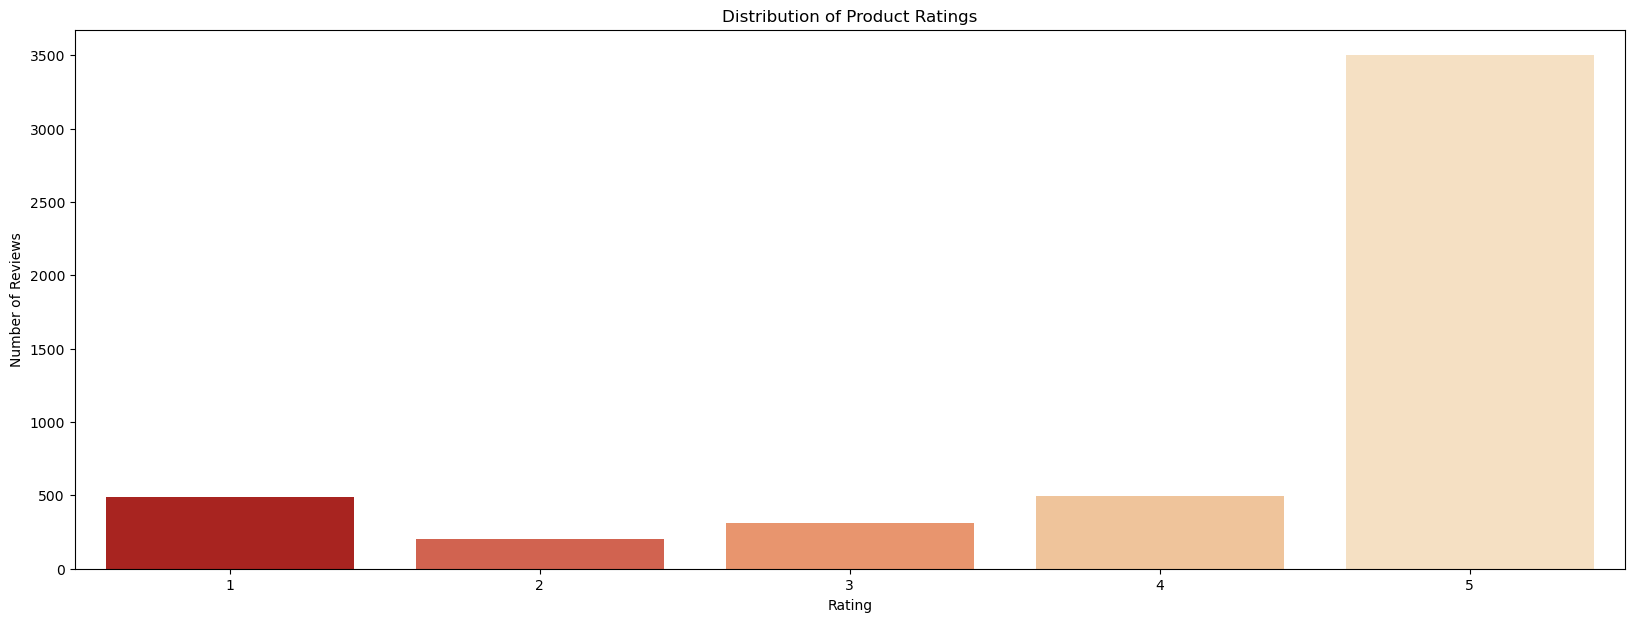

In [190]:
import seaborn as sns

f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=df["overall"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()



If the model simply classified every review as 5, then an accuracy of around 60% can be achieved given this exact dataset. Since this would outperform predictions made by chance, we should therefore ensure that we stratify the testing set where we base the final score of the model.

To deal with this we will have to take into account underrepresenting the majority and/or overrepresenting the minority.


In [191]:
majority = df["overall"] == 5
majority_ratio = len(df[majority]) / len(df)

print(f"{majority_ratio*100:.2f}%")

69.98%


---

### <span style="color: #2e6c80;">&#128295; Addressing Class Imbalance: Underrepresentation vs. Overrepresentation</span>

---

#### <span style="color: #a46497;">&#10148; Overview</span>
<span style="font-size: 16px;">We discuss strategies to tackle the issue of class imbalance by either overrepresenting the minority classes or underrepresenting the majority classes.</span>

---

#### <span style="color: #a46497;">&#128226; Overrepresentation</span>
<span style="font-size: 16px;">Performing over-representation is possible by bootstrapping the minority classes using techniques like K-Nearest Neighbors (KNN) or Support Vector Machine (SVM). SMOTE (Synthetic Minority Over-sampling Technique) is a popular module that executes this. However, given the size of our dataset and the dimensionality, this approach is computationally expensive.</span>

---

#### <span style="color: #a46497;">&#128299; Underrepresentation</span>
<span style="font-size: 16px;">Because our dataset is extensive, we can afford to sample every class and still retain sufficient data for the model. This allows us to underrepresent the majority class, aligning it with the size of the most minority class.</span>

---


In [192]:
count = len(model_df[model_df["label"] == 2])
print(f"Size of the most underrepresented class: {count}")

Size of the most underrepresented class: 202




In choosing this route to deal with imbalance, we create a trimmed version of our dataframe, trimmed_df. Each class is trimmed to have the same number of entries as the smallest class which is Class 2.


In [193]:
#trim the majority class
condition = model_df["label"] == 5
trimmed_df = model_df[condition].sample(n=count, random_state=42)

#trim other class and add on to the trimmed_df
for rating in [1, 2, 3, 4]:
    condition = model_df["label"] == rating
    if len(model_df[condition]) >= count:
        add_df = model_df[condition].sample(n=count, random_state=42)
    else:
        add_df = model_df[condition]
    trimmed_df = pd.concat([trimmed_df, add_df], ignore_index=False)

#display new class sizes of trimmed_df
for rating in [1, 2, 3, 4, 5]:
    class_size = len(trimmed_df[trimmed_df["label"] == rating])
    print(f"Size of Class {rating}: {class_size}")

Size of Class 1: 202
Size of Class 2: 202
Size of Class 3: 202
Size of Class 4: 202
Size of Class 5: 202




The trimmed_df is arranged by class from 1 to 5.


In [194]:
trimmed_df = trimmed_df.sort_values(by="label")
display(trimmed_df.head())


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
3399,0.152335,-0.338555,-0.071303,0.309586,0.220380,0.888966,0.097114,0.691642,-0.711266,0.238153,...,0.502590,-0.142646,-0.273424,0.364407,-0.188669,-0.261025,0.382114,0.017852,-0.995039,1
1298,0.194269,-0.424741,-0.093740,0.388723,0.276103,1.100631,0.119909,0.858694,-0.879531,0.297831,...,0.621876,-0.175270,-0.346174,0.448497,-0.235794,-0.323182,0.470483,0.010134,-1.249674,1
1216,0.148557,-0.334483,-0.070375,0.303906,0.213710,0.877488,0.096057,0.682569,-0.697879,0.236755,...,0.499748,-0.139880,-0.276879,0.357191,-0.183580,-0.261181,0.374987,0.015395,-0.993143,1
2689,0.118679,-0.252644,-0.057126,0.229764,0.161153,0.651526,0.067179,0.518625,-0.527757,0.178428,...,0.371429,-0.104646,-0.200853,0.273324,-0.138388,-0.191317,0.284355,0.004098,-0.742787,1
4804,0.140051,-0.310185,-0.061924,0.288325,0.195605,0.819397,0.092264,0.635950,-0.652210,0.217786,...,0.466921,-0.128987,-0.255372,0.333190,-0.172566,-0.238265,0.354351,0.014091,-0.913597,1




We see that we now have a perfectly balanced dataset after we performed underrepresentation.


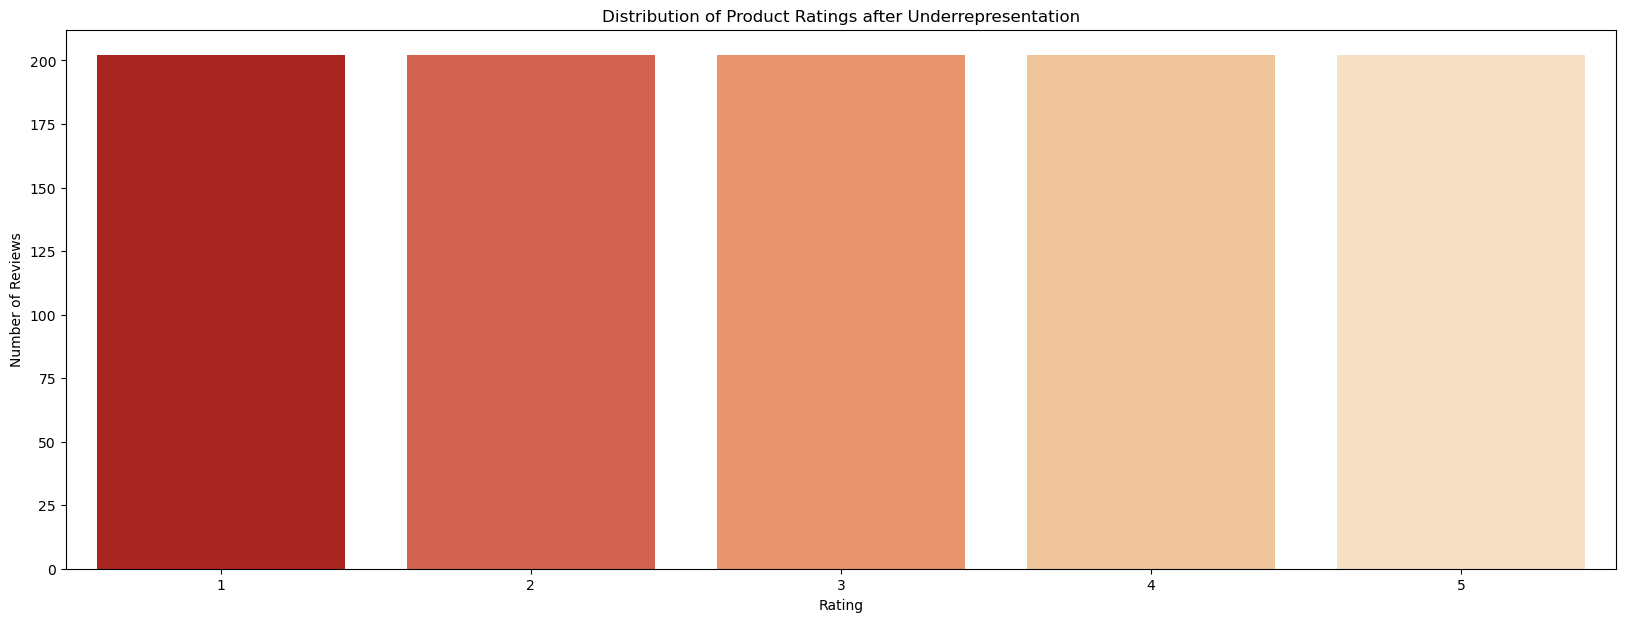

In [195]:
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=trimmed_df["label"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings after Underrepresentation", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()


Train-Test Split

The y is our target variable or the labels for the data. The X constitutes the features and are the predictor variables.

We evenly split the training and testing sets and stratify to ensure the ratio of classes in both sets are identical.


In [196]:
from sklearn.model_selection import train_test_split

X = trimmed_df.iloc[:, :-1]
y = trimmed_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

---

### <span style="color: #2e6c80;">&#128200; Scoring and Baseline</span>

---

#### <span style="color: #a46497;">&#128203; Overview</span>
<span style="font-size: 16px;">We will use two key metrics, Accuracy and F1 Score, to evaluate the performance of our machine learning model.</span>

---

#### <span style="color: #a46497;">&#128302; Metrics</span>

- **Accuracy**: Measures how many reviews are correctly labeled by the model. In a 5-class problem, a purely random guess would yield an accuracy of 20%.
  
- **F1 Score**: Combines precision and recall, taking into account false positives and false negatives. This is crucial for inherently imbalanced datasets.

---

#### <span style="color: #a46497;">&#9889; Baseline</span>
<span style="font-size: 16px;">The baseline scores are derived from a model that randomly guesses output labels or predicts a constant class for all samples. These scores are also calculated assuming an evenly distributed dataset.</span>

---


In [197]:
from sklearn import metrics

label_shape = np.shape(y_test)
y_baseline = np.full(label_shape, 5)

accuracy_baseline = metrics.accuracy_score(y_test, y_baseline)
f1_score_baseline = metrics.f1_score(y_test, y_baseline, average="micro")

print(f"Baseline Accuracy: {accuracy_baseline*100:.3f}%")
print(f"Baseline F1 Score: {f1_score_baseline:.3f}")

Baseline Accuracy: 20.000%
Baseline F1 Score: 0.200



Random Forest

Random Forest actually has a native way of supporting datasets that have class imbalance. We will therefore be able to use the original model_df instead of the sample trimmed_df:


In [198]:
from sklearn.model_selection import train_test_split

X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)



The class_weight attribute is provided with a dictionary that represents the associated weight of each class – the majority class is given a 1 and the rest are given the multiplying factor at which they would level with the largest class.

The criteria chosen is entropy which is similar to gini but instead of splitting nodes until there are pure classes, the nodes are split until the classes within have equal probability.


In [199]:
%%time
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=25, class_weight={1:10, 2:12, 3:7, 4:9, 5:1}, \
                                criterion="entropy", random_state=42)
forest.fit(X_train, y_train)

CPU times: user 488 ms, sys: 42 µs, total: 488 ms
Wall time: 499 ms


RandomForestClassifier(class_weight={1: 10, 2: 12, 3: 7, 4: 9, 5: 1},
                       criterion='entropy', n_estimators=25, random_state=42)



Our tuned Random Forest model got a very high score on the training data. The confusion matrix plotted below highlighted how the model almost perfectly classified each Amazon review accordingly.

However, these scores may be misleading since they are based on the data that the model were trained on. This is highly likely a result of overfitting. It is then important to rate our model more effectively without digging into our reserved test set.


In [200]:
y_pred = forest.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

Training Set Accuracy: 98.518%
Training Set F1 Score: 0.985


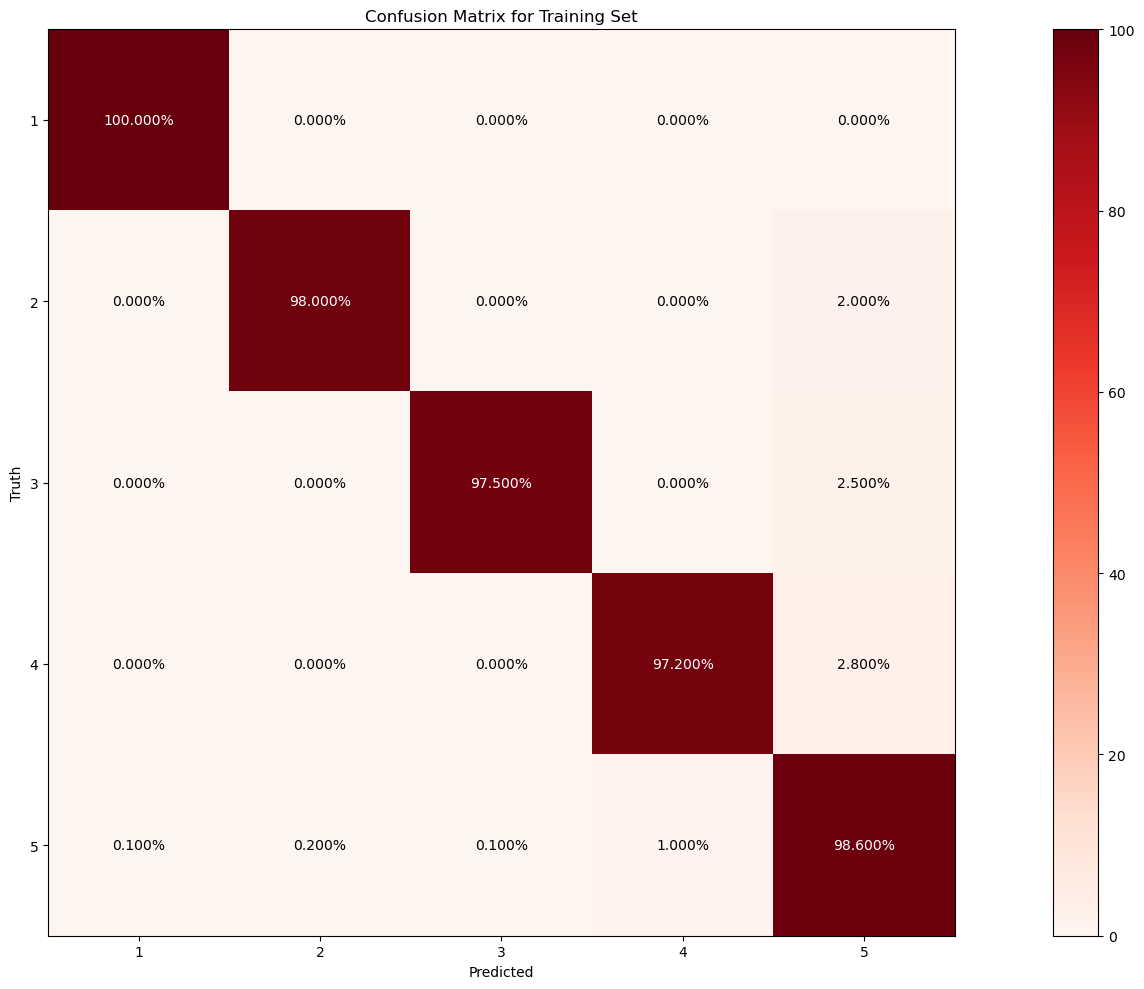

In [201]:
from sklearn.metrics import confusion_matrix

#create the confusion matrix of the training set
confusion_train = confusion_matrix(y_train, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Training Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()


Cross-Validation

Cross-validation makes the most of the training data by splitting the training set into folds and further subjecting each fold to train-test splits. Cross-validation can thus test against overfitting and the resulting scores can better reflect how the model performs on data it has not seen before.


In [202]:
from sklearn.model_selection import cross_val_score

cross_val_accuracy = cross_val_score(forest, X_train, y_train, \
                               cv=3, scoring="accuracy")
cross_val_f1 = cross_val_score(forest, X_train, y_train, \
                               cv=3, scoring="f1_micro")

cross_val_accuracy = np.mean(cross_val_accuracy)
cross_val_f1 = np.mean(cross_val_f1)

print(f"Training Set Accuracy: {cross_val_accuracy*100:.3f}%")
print(f"Training Set F1 Score: {cross_val_f1:.3f}")

Training Set Accuracy: 68.670%
Training Set F1 Score: 0.687



XGBoost

Let's now try to create a model based on a popular boosting technique and see how it compares with our Random Forest model (which is a tree-based bagging approach). XGBoost has become a staple in Kaggle competitions because of its high rate of success and its ease-of-use.

The class notation for our XGBoost object boost begins from 0, and so we perform an element-wise shift of our labels from 1 to 0, from 2 to 1, from 3 to 2, etc. We tune our model using the maximum number of depths, the learning rate (eta), the number of classes, etc. We expect our outputs to be multi-class and so we select softprob as our objective.


In [203]:
%%time
import xgboost as xgb

y_train_shifted = y_train-1
y_test_shifted = y_test-1

train_set = xgb.DMatrix(X_train, label=y_train_shifted)
test_set = xgb.DMatrix(X_test, label=y_test_shifted)

parameters = {"max_depth": 10, "eta": 0.2, "silent": 1, \
              "objective": "multi:softprob", "num_class": 5}

boost = xgb.train(parameters, train_set, 100)

CPU times: user 43.7 s, sys: 208 ms, total: 43.9 s
Wall time: 5.6 s




The array of predicted labels y_pred contains lists of probabilities for each class per product review. The class that is deemed most likely is chosen by the argmax and the labels are shifted back to their original state.

The micro approach in averaging the F1 score means that the false positives, true positives, and false negatives are taken into account across all classes. This is in contrast with the macro approach that instead averages the F1 scores of each class independently.


In [204]:
y_pred = boost.predict(train_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

Training Set Accuracy: 99.199%
Training Set F1 Score: 0.992


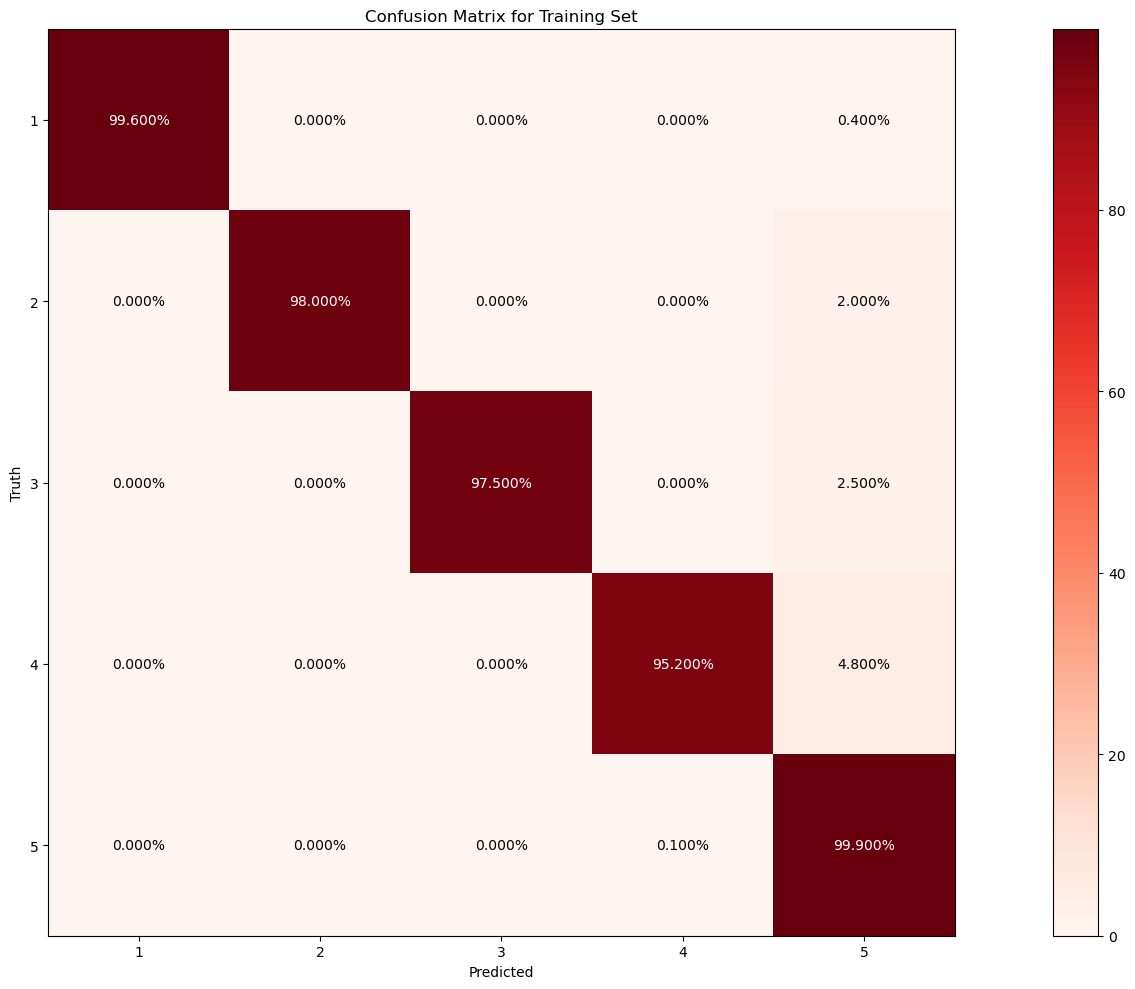

In [205]:
#create the confusion matrix of the training set
confusion_train = confusion_matrix(y_train, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Training Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()



To fairly compare our boosting results with our Random Forest outcome, we perform cross-validation on three folds of the training data set as well.

However, since the XGBoost implementation we used is not supported by scikit-learn's .fit method, the cross-validation must be done using xgboost's own API. The output boost_cv is actually a pandas dataframe that tabulates the results of the cross-validation.


In [206]:
%%time
boost_cv = xgb.cv(dtrain=train_set, params=parameters, nfold=3, \
                  num_boost_round=50, early_stopping_rounds=10, \
                  metrics="merror", as_pandas=True, seed=42)

display(boost_cv.head())


,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.126202,0.012384,0.357372,0.005405
1,0.099760,0.011497,0.336138,0.004939
2,0.081931,0.006385,0.329728,0.005750
3,0.070112,0.007150,0.326522,0.003446
4,0.064103,0.005201,0.325721,0.002596


CPU times: user 1min 1s, sys: 375 ms, total: 1min 1s
Wall time: 7.77 s




We get the training set cross-validation score by getting the merror mean on the 50th num_boost_round, which is the final boosting phase. The merror is an accuracy error rate metric meant for multi-class labels.

We can get a sense of how accurate the model is by subtracting the merror value from a perfect score of 100%.



Final Scores

Seeing that the boosting model outperformed the Random Forest approach in the three-fold cross validation, we can now apply our model on the testing set that we have put aside early on.


In [207]:
y_pred = boost.predict(test_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average="micro")

print(f"Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Test Set F1 Score: {f1_score:.3f}")

Test Set Accuracy: 69.684%
Test Set F1 Score: 0.697


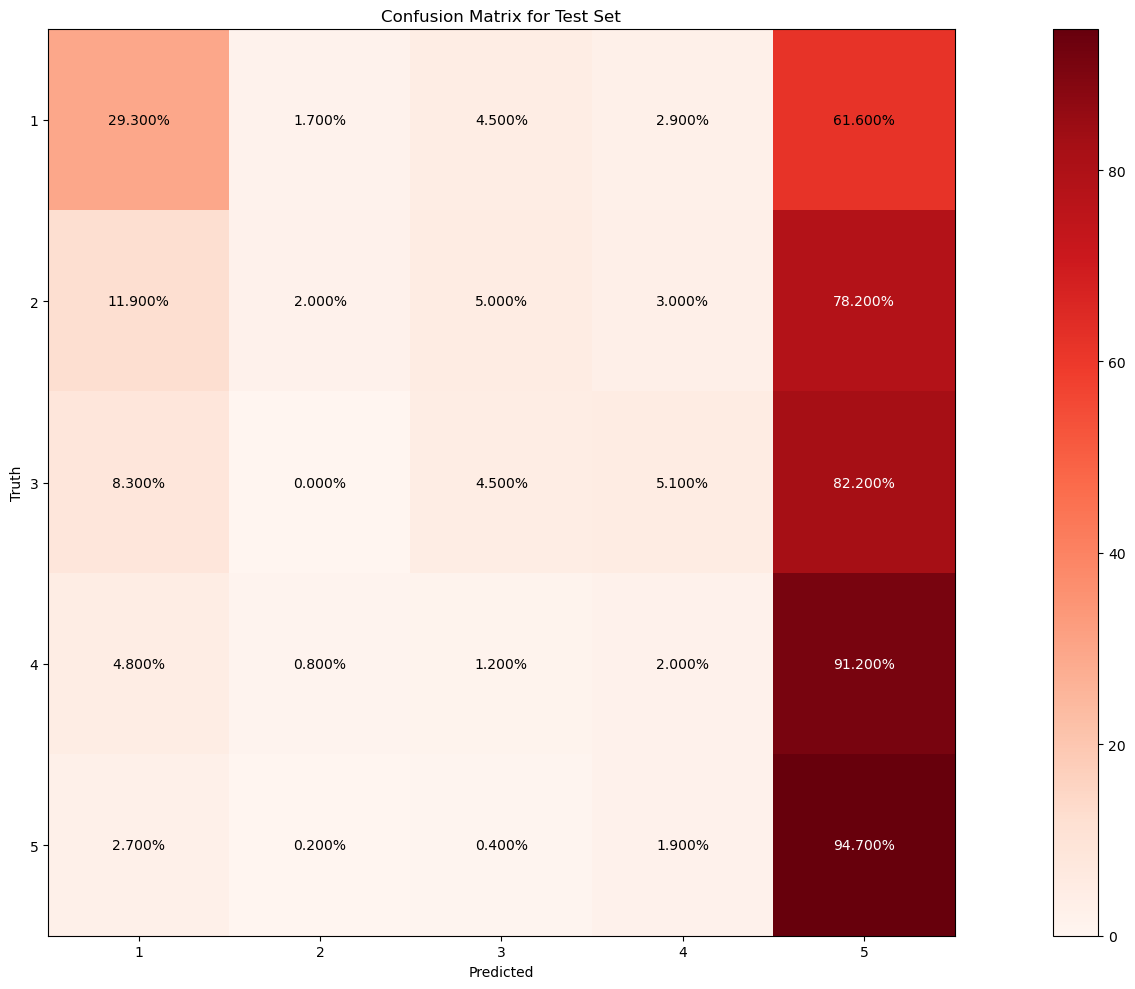

In [208]:
#create the confusion matrix of the test set
confusion_train = confusion_matrix(y_test, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Test Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

Our results above were actually based on the original model_df dataset that had the massive class imbalance. Let's now reassign our X and y variables to the balanced trimmed_df sample dataset we've created.

In [209]:
X = trimmed_df.iloc[:, :-1]
y = trimmed_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

In [210]:
y_train_shifted = y_train-1
y_test_shifted = y_test-1

train_set = xgb.DMatrix(X_train, label=y_train_shifted)
test_set = xgb.DMatrix(X_test, label=y_test_shifted)

y_pred = boost.predict(test_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average="micro")

print(f"Balanced Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Balanced Test Set F1 Score: {f1_score:.3f}")

Balanced Test Set Accuracy: 69.505%
Balanced Test Set F1 Score: 0.695


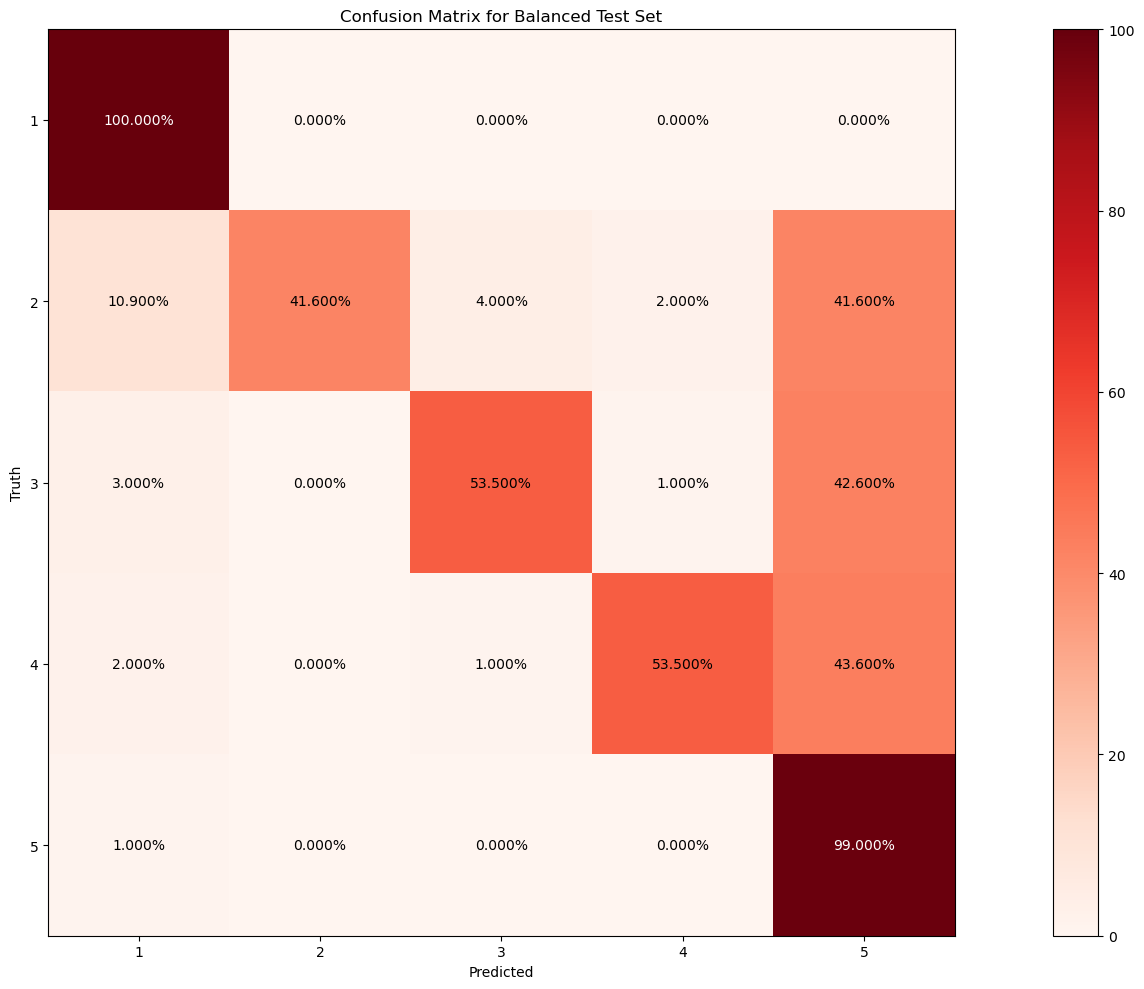

In [211]:
#create the confusion matrix of the balanced test set
confusion_train = confusion_matrix(y_test, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Balanced Test Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

Word Cloud

Using the true labels of the reviews, we can take the fifty most salient words in every rating and produce a word cloud. The same stop_words we derived from the NLTK library are excluded.

We see that some of the words are quite descriptive of the rating, with "problem" and "issue" frequently appearing in one-star reviews, and "quality" and "highly recommend" in top reviews.

In [1]:
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords = set(stop_words), min_font_size=10, \
                      max_font_size=50, max_words=50, \
                      background_color="white", colormap = "Oranges")

one_star_text = " ".join(df[df["overall"]==1]["reviewText"].values).lower()
two_star_text = " ".join(df[df["overall"]==2]["reviewText"].values).lower()
three_star_text = " ".join(df[df["overall"]==3]["reviewText"].values).lower()
four_star_text = " ".join(df[df["overall"]==4]["reviewText"].values).lower()
five_star_text = " ".join(str(df[df["overall"]==5]["reviewText"].values)).lower()

text_list = [one_star_text, two_star_text, three_star_text, \
             four_star_text, five_star_text]

for index, text in enumerate(text_list):
    f, axes = plt.subplots(figsize=(10,7))
    wordcloud.generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for {index+1}-Star Ratings")
    plt.axis("off")
    plt.show()

NameError: name 'stop_words' is not defined

---

### <span style="color: #4CAF50;">&#127942; Conclusion</span>

---

#### <span style="color: #9C27B0;">&#128214; Summary of Methods</span>
In our study, a multitude of NLP techniques were explored, including topic modeling, named entity recognition (NER), and dependency trees. The pre-processing steps, including tokenization, text normalization, and feature engineering, played a significant role alongside our main Word2Vec model.

---

#### <span style="color: #9C27B0;">&#128296; Insights from the Model</span>
Our model successfully quantifies the context around each token, expressing the interactions through vectors. We implemented a multi-class approach, where the classes are independent and correspond to the star ratings of the reviews. 

---

#### <span style="color: #9C27B0;">&#128295; Model Behavior and Distinctions</span>
The model focuses on what distinguishes each type of review, rather than assessing them on a continuum. Misclassification between two distant classes, like 1-star and 5-star, is treated as a simple mislabeling without considering the severity of the error.

---

#### <span style="color: #9C27B0;">&#128161; Limitations and Recommendations</span>
1. **Unknown Words**: The model can't handle words it hasn't seen during training. 
2. **Misspellings**: Despite lemmatization, the model can't recognize misspelled words.
3. **Sarcasm**: NLP models typically struggle with detecting sarcasm, which requires understanding mood and sentiment, adding a layer of complexity.

---

